# Optimal Location to Open Poke Restaurant in Seattle
**Matt Pierce**  
"Future" Data Scientist

## Table of contents
1. [Introduction / Business Problem](#introduction)
2. [Data Acquisition](#DataAcquisition)
3. [Explore & Cluster Neighborhoods](#cluster)
7. [Footnotes](#footnotes)

## 1. Introduction / Business Problem <a name="introduction"></a>

### 1.1 Pre-Introduction

This research paper is my capstone project (course ##9) for the IBM Data Science Professional Certificate.

(https://www.coursera.org/professional-certificates/ibm-data-science#howItWorks).

### 1.2 Introduction

Poke restaurants are an innovative and healthy Hawaiian cuisine that are seeing growing demand.[1]  Poke “build-your-own” bowl flexibility allows diners to choose from multiple bases[2] (salad, rice or quinoa), multiple protein sources[2] (salmon, tuna, octopus, red snapper, etc.), and multiple toppings[2] (10+ sauces and oils, seeds, onions, cucumbers, crab-salad, seaweed, dices mangoes or oranges, and much more).  Poke bowls generally offer superior nutrition and taste relative to other fast food options[3].

### 1.3 Business Problem

The objective of this research project is to analyze and select the best location in Seattle for our “hypothetical” client to open a new Poke Restaurant.  S/he already owns and operates one Poke restaurant just North of Seattle and is looking to expand by opening a second somewhere in Seattle.

Searching for the optimal location is challenging because it is not as simple as finding a geographic gap where there is not yet a Poke restaurant.  It is more complex in that potential customers aren’t interested in driving out to an isolated neighborhood with one Poke restaurant; but rather they prefer frequenting common clusters of restaurants(see “clustering” game theory[4]…not to be confused with “clustering” algorithms[5])  However, caution must be taken to carefully select the best location, because there is risk that the Poke market is already oversaturated[6] with 68 Poke restaurants currently in Seattle as per a Google Map search (via jump to last-in-list).[7]

To address this business problem, research will be done using data science methodology and machine learning techniques such as clustering to find and rank the best locations.

### 1.4 Install Libraries

The following libraries are left uncommented to harmlessly run and pop a messagebox indicating that the library is already installed.  There might be reasons to comment this out however, and if you need to, they are all isolated up here.


In [1]:
#! pip install numpy  

In [2]:
#! pip install pandas

In [3]:
#! pip install matplotlib

In [4]:
#! pip install seaborn

In [5]:
#! pip install sklearn

In [6]:
#! pip install pygeocoder

In [7]:
#! pip install folium==0.5.0

In [8]:
#! pip install geopy

### 1.5 Import Libraries

In [9]:
import numpy as np # library to handle data in a vectorized manner

In [10]:
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

In [11]:
import requests # library to handle requests

In [12]:
from pandas.io.json import json_normalize # library to tranform JSON file into a pandas dataframe

In [13]:
import matplotlib.cm as cm           # Matplotlib and associated plotting modules
import matplotlib.colors as colors

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter  
from matplotlib.ticker import PercentFormatter  

In [14]:
import seaborn as sns # library for data visualization, fancier graphs built on top of matplotlib

In [15]:
from sklearn.cluster import KMeans # library for k-means clustering 

In [16]:
from pygeocoder import Geocoder

In [17]:
from geopy.geocoders import Nominatim

In [18]:
import folium

In [19]:
print('Libraries imported.')

Libraries imported.


## 2. Data Acquisition <a name="DataAcquisition"></a>

### 2.1 Data Sources

The data and tools that I will use are the following:

* **Seattle OpenData** to split city into 42 neighborhoods with demographics (population, density, renters, etc.)
* **Geocoder** to get the latitudes and longitudes for neighborhoods of Seattle OpenData CSV list
* **Foursquare API** to determine neighborhood breakdown: # restaurants, # Poke restaurants, urban style, etc.

### 2.2 Feature Selection

#### 2.2.1 Load  Seattle Neighborhoods, ZIpcodes, and Demographics from CSV
Turns out it was faster and cleaner to do some manual scrubbing in Excel first to generate a partially combined CSV data file containing Seattle Neighborhoods, zipcodes, and demographics of interest.  

The data sources were one CSV and one PDF file:
* https://opendata.arcgis.com/datasets/5319b05188d744319e01b4ce4be6b853_0.csv [8]
* http://www.agingkingcounty.org/wp-content/uploads/sites/185/2016/09/SubRegZipCityNeighborhood.pdf [12]

The first step is to load the CSV file into a dataframe for processing using Pandas read_csv command, then look at the number of rows and columns, then preview the first 5 rows:

In [20]:
# Load CSV into DataFrame
df_X = pd.read_csv("seattle_neighborhoods_zipcodes_geoloc_demographics.csv", dtype={"Zipcode":str})

# Drop Column "OBJECTID"
del df_X['OBJECTID']

# Rename the columns
df_raw = df_X.rename(columns = {'Type_Name':'Type'})
                                               
# Verify
print(df_raw.shape)
df_raw.head()

(48, 10)


,Zipcode,Borough,Neighborhood,Type,Acres,Total_Pop,Median_Age,Occ_Units,Owner_Occ,Renter_Occ
0,98101,Downtown,Commercial Core,Urban Center Village,276.4,5917,45.9,2985,662,2323
1,98101,East,Pike/Pine,Urban Center Village,130.9,4413,32.0,3076,703,2373
2,98101,Downtown,Denny Triangle,Urban Center Village,142.7,3248,36.5,2073,404,1669
3,98102,Lake Union,Eastlake,Residential Urban Village,200.2,5084,37.0,3118,878,2240
4,98103,Lake Union,Wallingford,Residential Urban Village,257.1,5350,34.2,2780,935,1845


#### 2.2.2 Cleanup Data
Drop rows having Zipcode = 0.  Drop NaN and Null rows at Borough, Neighborhood, and Type.  Also, add a calculated column that pre-positions a weighted Median_Age so that we can roll it up to zipcode properly (avoiding "average of an average" error).

In [21]:
# Delete rows with bogus values that cause errors downstream
df_clean = df_raw.drop(df_raw[df_raw.Zipcode=="0"].index)
df_clean = df_clean.dropna(subset=['Type']).reset_index(drop=True)

# Verify
print(df_clean.shape)
df_clean.head()

(46, 10)


,Zipcode,Borough,Neighborhood,Type,Acres,Total_Pop,Median_Age,Occ_Units,Owner_Occ,Renter_Occ
0,98101,Downtown,Commercial Core,Urban Center Village,276.4,5917,45.9,2985,662,2323
1,98101,East,Pike/Pine,Urban Center Village,130.9,4413,32.0,3076,703,2373
2,98101,Downtown,Denny Triangle,Urban Center Village,142.7,3248,36.5,2073,404,1669
3,98102,Lake Union,Eastlake,Residential Urban Village,200.2,5084,37.0,3118,878,2240
4,98103,Lake Union,Wallingford,Residential Urban Village,257.1,5350,34.2,2780,935,1845


In [22]:
# Multiply each original row's Median_Age times number of Total_Pop to weight the Median_Age for subsequent averaging
df_clean['Weighted_Age'] = df_clean['Median_Age'] * df_clean['Total_Pop']
df_clean.head()

,Zipcode,Borough,Neighborhood,Type,Acres,Total_Pop,Median_Age,Occ_Units,Owner_Occ,Renter_Occ,Weighted_Age
0,98101,Downtown,Commercial Core,Urban Center Village,276.4,5917,45.9,2985,662,2323,271590.3
1,98101,East,Pike/Pine,Urban Center Village,130.9,4413,32.0,3076,703,2373,141216.0
2,98101,Downtown,Denny Triangle,Urban Center Village,142.7,3248,36.5,2073,404,1669,118552.0
3,98102,Lake Union,Eastlake,Residential Urban Village,200.2,5084,37.0,3118,878,2240,188108.0
4,98103,Lake Union,Wallingford,Residential Urban Village,257.1,5350,34.2,2780,935,1845,182970.0


#### 2.2.3 De-Dup Zipcodes and Rollup Values
Rollup zipcodes to one row each for the table.  Concatenate string type fields Neighborhoods, boroughs, and Types into comma delimited descriptions.  Sum numeric fields Acres, Total_Pop, Occ_Units, Owner_Occ, and Renter_Occ.  Going to improvise on Median age rollup to avoid the "average of an average" problem by multiplying each zipcode by the Total_Pop to maintain weighting.

In [23]:
# Derive comma separate list of Boroughs per Zipcode
df_X = df_clean[['Zipcode','Borough']]
df_X2 = df_X.join(df_X.Zipcode.map(df_X.groupby('Zipcode').Borough.unique().str.join(', ')).rename('Boroughs'))
df_zip_boroughs = df_X2[['Zipcode','Boroughs']].groupby('Zipcode').min()

# Verify
print(df_zip_boroughs.shape)
df_zip_boroughs.head()

(29, 1)


,Boroughs
Zipcode,
98101,"Downtown, East"
98102,Lake Union
98103,"Lake Union, Northwest"
98104,"Downtown, East"
98105,Northeast


In [24]:
# Derive comma separate list of Neighborhoods per Zipcode
df_X = df_clean[['Zipcode','Neighborhood']]
df_X2 = df_X.join(df_X.Zipcode.map(df_X.groupby('Zipcode').Neighborhood.unique().str.join(', ')).rename('Neighborhoods'))
df_zip_hoods = df_X2[['Zipcode','Neighborhoods']].groupby('Zipcode').min()

# Verify
print(df_zip_hoods.shape)
df_zip_hoods.head()

(29, 1)


,Neighborhoods
Zipcode,
98101,"Commercial Core, Pike/Pine, Denny Triangle"
98102,Eastlake
98103,"Wallingford, Aurora-Licton Springs, Fremont"
98104,"Madison-Miller, First Hill, Pioneer Square"
98105,Admiral


In [25]:
# Derive comma separate list of Types per Zipcode
df_X = df_clean[['Zipcode','Type']]
df_X2 = df_X.join(df_X.Zipcode.map(df_X.groupby('Zipcode').Type.unique().str.join(', ')).rename('Types'))
df_zip_types = df_X2[['Zipcode','Types']].groupby('Zipcode').min()

# Verify
print(df_zip_types.shape)
df_zip_types.head()

(29, 1)


,Types
Zipcode,
98101,Urban Center Village
98102,Residential Urban Village
98103,"Residential Urban Village, Hub Urban Village"
98104,"Residential Urban Village, Urban Center Village"
98105,Residential Urban Village


In [26]:
# Combine 3 String fields by Zipcode
df_zip_3str = pd.merge(df_zip_boroughs, df_zip_hoods, on="Zipcode", how="left")
df_zip_3str = pd.merge(df_zip_3str, df_zip_types, on="Zipcode", how="left")

# Verify
print(df_zip_3str.shape)
df_zip_3str.head()

(29, 3)


,Boroughs,Neighborhoods,Types
Zipcode,,,
98101,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",Urban Center Village
98102,Lake Union,Eastlake,Residential Urban Village
98103,"Lake Union, Northwest","Wallingford, Aurora-Licton Springs, Fremont","Residential Urban Village, Hub Urban Village"
98104,"Downtown, East","Madison-Miller, First Hill, Pioneer Square","Residential Urban Village, Urban Center Village"
98105,Northeast,Admiral,Residential Urban Village


In [27]:
# Append Summable Numeric Columns 'Acres', 'Total_Pop', etc. as Sum()'s rolled up to Zipcode level
df_base = pd.merge(df_zip_3str, df_clean.groupby('Zipcode')['Acres'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Total_Pop'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Occ_Units'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Owner_Occ'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Renter_Occ'].sum(), on="Zipcode", how="left")
df_base = pd.merge(df_base, df_clean.groupby('Zipcode')['Weighted_Age'].sum(), on="Zipcode", how="left")

# Verify
print(df_base.shape)
df_base.head()

(29, 9)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Occ_Units,Owner_Occ,Renter_Occ,Weighted_Age
Zipcode,,,,,,,,,
98101,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",Urban Center Village,550.0,13578,8134,1769,6365,531358.3
98102,Lake Union,Eastlake,Residential Urban Village,200.2,5084,3118,878,2240,188108.0
98103,"Lake Union, Northwest","Wallingford, Aurora-Licton Springs, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,8167,2742,5425,517539.9
98104,"Downtown, East","Madison-Miller, First Hill, Pioneer Square","Residential Urban Village, Urban Center Village",515.8,14999,8791,1491,7300,606479.4
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,962,259,703,64634.4


#### 2.2.4 Calculate Densities and Percent Rental Units
Add three density columns "Dens_Tot_Pop", "Dens_Home_Own", and "Dens_Apt_Dw".  Calculate their values given the Acres per Zipcode, the total population, the owner occupied and renter occupied unit counts.

In [28]:
# Calculate three densities and tack on percent Rental units
df_base["Pop_Dens"] = df_base["Total_Pop"] / df_base["Acres"]
df_base["Prc_Own"] = df_base["Owner_Occ"] / df_base["Occ_Units"]
df_base["Prc_Rent"] = df_base["Renter_Occ"] / df_base["Occ_Units"]
df_base["Median_Age"] = df_base["Weighted_Age"] / df_base["Total_Pop"]

# Strip down to just the columns we need to carry forward 
# New subset DataFrame with just the columns we want to extract out of df_sea_neigh_raw
df_base = df_base[["Boroughs","Neighborhoods","Types","Acres","Total_Pop","Median_Age", 
                    "Pop_Dens","Prc_Own","Prc_Rent"]]

# Verify Results
print(df_base.shape)
df_base.head()

(29, 9)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent
Zipcode,,,,,,,,,
98101,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",Urban Center Village,550.0,13578,39.133768,24.687273,0.217482,0.782518
98102,Lake Union,Eastlake,Residential Urban Village,200.2,5084,37.000000,25.394605,0.281591,0.718409
98103,"Lake Union, Northwest","Wallingford, Aurora-Licton Springs, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,33.413384,19.395192,0.335741,0.664259
98104,"Downtown, East","Madison-Miller, First Hill, Pioneer Square","Residential Urban Village, Urban Center Village",515.8,14999,40.434656,29.079100,0.169605,0.830395
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,42.300000,15.544252,0.269231,0.730769


#### 2.2.5 Load Seattle Latitudes and Longitudes by Zipcode from CSV
Looked all over and could not find a readily downloadable and consumable Seattle zipcode with latitude and longitude values.  Found a PDF online that purports to identify the coordinates center of mass per zipcode...so went with that and manually entered the 29-ish zipcode into a CSV.  One time where simple brute force is faster than taking the time to dial in BeautifulSoup code to scrape a PDF (if it were HTML, I'd have coded it).

The data source for the PDF geo coordinates per Zipcode is:
* https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=WA&q=Seattle [13]

In [29]:
# Load CSV into DataFrame
df_X = pd.read_csv("seattle_zipcode_latitude_longitude.csv", dtype={"Zipcode":str})

# New subset DataFrame with just the columns we want to extract out of df_sea_neigh_raw
df_X2 = df_X[["Zipcode", "Latitude", "Longitude"]]

# Convert Zipcode to index so subsequent step can merge
df_coord = df_X2[['Zipcode','Latitude','Longitude']].groupby('Zipcode').min()

# Verify
print(df_coord.shape)
df_coord.head()

(29, 2)


,Latitude,Longitude
Zipcode,,
98101,47.610670,-122.33438
98102,47.632870,-122.32253
98103,47.671346,-122.34166
98104,47.602520,-122.32855
98105,47.663770,-122.30118


In [30]:
df_coord

,Latitude,Longitude
Zipcode,,
98101,47.610670,-122.334380
98102,47.632870,-122.322530
98103,47.671346,-122.341660
98104,47.602520,-122.328550
98105,47.663770,-122.301180
98106,47.532820,-122.354430
98107,47.667470,-122.374680
98108,47.546188,-122.315140
98109,47.630648,-122.346750


In [31]:
# Merge these coordinates into the main zip data frame
df_seattle = pd.merge(df_base, df_coord, on="Zipcode", how="right")

# Verify final shape
print(df_seattle.shape)
df_seattle.head()

(29, 11)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude
Zipcode,,,,,,,,,,,
98101,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",Urban Center Village,550.0,13578,39.133768,24.687273,0.217482,0.782518,47.610670,-122.33438
98102,Lake Union,Eastlake,Residential Urban Village,200.2,5084,37.000000,25.394605,0.281591,0.718409,47.632870,-122.32253
98103,"Lake Union, Northwest","Wallingford, Aurora-Licton Springs, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,33.413384,19.395192,0.335741,0.664259,47.671346,-122.34166
98104,"Downtown, East","Madison-Miller, First Hill, Pioneer Square","Residential Urban Village, Urban Center Village",515.8,14999,40.434656,29.079100,0.169605,0.830395,47.602520,-122.32855
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,42.300000,15.544252,0.269231,0.730769,47.663770,-122.30118


#### 2.2.6 Checkpoint
Verify the dataset looks good.  Save it out to CSV locally.

In [32]:
# Verifications below caught issue where Total_Pop was float but really should be int...fixing here, then re-verify below
df_seattle.Total_Pop = df_seattle.Total_Pop.astype(int)

In [33]:
# Verify no nulls, data good to go
df_seattle.isnull().sum()

Boroughs         0
Neighborhoods    0
Types            0
Acres            0
Total_Pop        0
Median_Age       0
Pop_Dens         0
Prc_Own          0
Prc_Rent         0
Latitude         0
Longitude        0
dtype: int64

In [34]:
# Verify basic info
df_seattle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 98101 to 98199
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Boroughs       29 non-null     object 
 1   Neighborhoods  29 non-null     object 
 2   Types          29 non-null     object 
 3   Acres          29 non-null     float64
 4   Total_Pop      29 non-null     int32  
 5   Median_Age     29 non-null     float64
 6   Pop_Dens       29 non-null     float64
 7   Prc_Own        29 non-null     float64
 8   Prc_Rent       29 non-null     float64
 9   Latitude       29 non-null     float64
 10  Longitude      29 non-null     float64
dtypes: float64(7), int32(1), object(3)
memory usage: 2.6+ KB


In [35]:
df_seattle.to_csv('seattle_neighborhoods_checkpoint.csv')

## 3. Explore & Cluster Neighborhoods <a name="cluster"></a>

### 3.1 Level Set with Map of Seattle
#### 3.1.1 Get Geographic Coordinates of Seattle

In [36]:
address = "Seattle"
geolocator = Nominatim(user_agent='us_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Seattle are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Seattle are 47.6038321, -122.3300624.


#### 3.1.2 Preliminary Map of Seattle
Spin up a map of Seattle, and drop our geo-coordinates from the DataFrame above to make sure it all looks good so far.

In [37]:
# NOTE - This step caught an error with zipcode vs. latitude/longitude mappings...an outlier...corrected CSV and re-ran

# create map of Toronto using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_seattle['Latitude'], df_seattle['Longitude'], df_seattle['Boroughs'], df_seattle['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  

map_seattle

### 3.2 Use Foursquare API to Explore and Segment Neighborhoods
#### 3.2.1 Set Foursquare Credentials

In [38]:
# My throw-away credentials for this project
CLIENT_ID = '52JKLAGJPSSWR4YQ3CVLUHCKAOKQJXS5WJJ03WTBVYL1EYH4' # your Foursquare ID
CLIENT_SECRET = 'QKS1ZH4F4KUUGK4WB402PUKBYADMCJWJIFMZUJR0ZRDZZKYO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 52JKLAGJPSSWR4YQ3CVLUHCKAOKQJXS5WJJ03WTBVYL1EYH4
CLIENT_SECRET:QKS1ZH4F4KUUGK4WB402PUKBYADMCJWJIFMZUJR0ZRDZZKYO


#### 3.2.2 Generic Function To Call Foursquare API

In [41]:
# Generic Function
def getNearbyVenues(cities, names, latitudes, longitudes, LIMIT=100, radius=500):
    # boroughs   = dataframe column filled with borough (city) names
    # names      = dataframe column filled with neighborhood names or zipcodes or bureuas
    # latitudes  = dataframe column filled with latitudes mapping directly to the names
    # longitudes = dataframe column filled with longitudes mapping directly to the names
    # LIMIT      = default is 100, limit the number of venues found per input row (name/lat/long combinations)
    # radius     = detault is 500, limits db search to this many meters...note that a city block is 80 meters, 
    venues_list=[]
    for city, name, lat, lng in zip(cities, names, latitudes, longitudes):
        print(city + ': ' + name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    df_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(df_venues)

#### 3.2.3 Fetch Venues For Our Seattle Neighborhoods

In [42]:
# IMPORTANT - Your firewall may block this application from making API calls out...if so, add an exception (or temp. turn off)

# Will use radius = 1,600 or 20 block radious x 80 meters/block

# Call generic function with parameters dialed in to our locations of interest (Neighborhoods)
seattle_venues_raw = getNearbyVenues(cities=df_seattle['Boroughs'],
                            names=df_seattle['Neighborhoods'],
                            latitudes=df_seattle['Latitude'],
                            longitudes=df_seattle['Longitude'],
                            LIMIT=100,
                            radius=1600  
                            )

Downtown, East: Commercial Core, Pike/Pine, Denny Triangle
Lake Union: Eastlake
Lake Union, Northwest: Wallingford, Aurora-Licton Springs, Fremont
Downtown, East: Madison-Miller, First Hill, Pioneer Square
Northeast: Admiral
Delridge: Westwood-Highland Park
Ballard: Ballard, Ballard-Interbay-Northend
Greater Duwamish: South Park, Columbia City
Lake Union: South Lake Union
Northeast, Northwest: Ravenna, Green Lake, Roosevelt
Southwest: West Seattle Junction
Ballard, Northwest: Crown Hill, Greenwood-Phinney Ridge
Southeast, Greater Duwamish: Othello, Columbia City
Downtown: Uptown
Downtown: Belltown
East: Chinatown-International District, Capitol Hill
North, Northwest: Lake City, Northgate
Downtown: Morgan Junction
Northwest: Bitter Lake Village
Downtown: Morgan Junction
East, Greater Duwamish: Chinatown-International District, Columbia City, North Beacon Hill
Southwest: West Seattle Junction
Downtown: Commercial Core
Southeast: Rainier Beach
Southeast: North Rainier
Southeast: Rainier B

In [43]:
# Verify Results
print(seattle_venues_raw.shape)
seattle_venues_raw.head()

(2332, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,ACT Theatre,47.610763,-122.332905,Theater
1,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Monorail Espresso,47.610828,-122.335048,Coffee Shop
2,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Din Tai Fung Dumpling House,47.612671,-122.335073,Dumpling Restaurant
3,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Nordstrom,47.612423,-122.335832,Women's Store
4,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Benaroya Hall,47.607957,-122.336456,Concert Hall


In [48]:
# Spot Check Neighborhood counts -- this led me to researching parameter radius = meters and settling on 20 blocks (1 mile)
#                                   to increase the number of hits (dfeault 500m had just 2 hits on one row)
seattle_venues_raw.groupby(["Borough", "Neighborhood"]).count()

Neighborhood Latitude  \
Borough                     Neighborhood                                                                
Ballard                     Ballard, Ballard-Interbay-Northend                                    100   
Ballard, Northwest          Crown Hill, Greenwood-Phinney Ridge                                   100   
Delridge                    Westwood-Highland Park                                                 45   
Downtown                    Belltown                                                              100   
                            Commercial Core                                                       100   
                            Morgan Junction                                                       104   
                            Uptown                                                                100   
Downtown, East              Commercial Core, Pike/Pine, Denny Triangle                            100   
                            Madison-Miller, First Hill, Pioneer Square                            100   
East                        Chinatown-International District, Capitol Hill                        100   
East, Greater Duwamish      Chinatown-International District, Columbia City...                    100   
Greater Duwamish            Greater Duwamish                                                      100   
                            South Park, Columbia City                                              86   
Lake Union                  Eastlake                                                              100   
                            South Lake Union                                                      100   
Lake Union, Northwest       Wallingford, Aurora-Licton Springs, Fremont                           100   
Magnolia/Queen Anne         Upper Queen Anne                                                       64   
North, Northwest            Lake City, Northgate                                                   84   
Northeast                   Admiral                                                               100   
                            University District Northwest, University Campus                      100   
Northeast, Northwest        Ravenna, Green Lake, Roosevelt                                        100   
Northwest                   Bitter Lake Village                                                    66   
Southeast                   North Rainier                                                          18   
                            Rainier Beach                                                          35   
Southeast, Greater Duwamish Othello, Columbia City                                                 84   
Southwest                   West Seattle Junction                                                 146   

                                                                                Neighborhood Longitude  \
Borough                     Neighborhood                                                                 
Ballard                     Ballard, Ballard-Interbay-Northend                                     100   
Ballard, Northwest          Crown Hill, Greenwood-Phinney Ridge                                    100   
Delridge                    Westwood-Highland Park                                                  45   
Downtown                    Belltown                                                               100   
                            Commercial Core                                                        100   
                            Morgan Junction                                                        104   
                            Uptown                                                                 100   
Downtown, East              Commercial Core, Pike/Pine, Denny Triangle                             100   
                            Madison-Miller, First Hill, Pioneer Square         

In [49]:
# Sanity Check for number of unique categories (expect more than 50)
print("Number of Unique Categories: ", len(seattle_venues_raw["Venue Category"].unique()))

Number of Unique Categories:  282


In [50]:
# Walk the return data, get a feel for it
seattle_venues_raw.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,ACT Theatre,47.610763,-122.332905,Theater
1,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Monorail Espresso,47.610828,-122.335048,Coffee Shop
2,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Din Tai Fung Dumpling House,47.612671,-122.335073,Dumpling Restaurant
3,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Nordstrom,47.612423,-122.335832,Women's Store
4,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Benaroya Hall,47.607957,-122.336456,Concert Hall


#### 3.2.4 Clean Venue Data

In [374]:
# IMPORTANT - Make a copy of DataFrame seattle_venues...so as I write the code, if make mistake do not have to re-call the
#             API and burn thru my daily allowance
seattle_venues = seattle_venues_raw[:].copy()

# Verify
print(seattle_venues.shape)
seattle_venues.head()

(2332, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,ACT Theatre,47.610763,-122.332905,Theater
1,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Monorail Espresso,47.610828,-122.335048,Coffee Shop
2,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Din Tai Fung Dumpling House,47.612671,-122.335073,Dumpling Restaurant
3,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Nordstrom,47.612423,-122.335832,Women's Store
4,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Benaroya Hall,47.607957,-122.336456,Concert Hall


In [375]:
# Our focus is on Restaurants and Related food type services for clustering; therefore, drop all categories (rows)
# like stadiums or art galleries

drop_keywords = ['Service','Shop','Store','Hotel','Museum','Court','Stadium','Theater','Hall','Bookstore'
                 ,'Garden','Park','Zoo','Spa','Grocery','Bus ','Gym','ATM'
                 ,'Playground','Station','Golf','Studio','Market','Club','Lookout','Airport','Doctor'
                 ,'Chiropractor','Dent','Pharmacy','Rental','Fountain','Trail','Center','Dealership'
                 ,'Gallery','Athletics','Baseball','Ferry','Boutique','Bowling','Arcade','Building','Bank'
                 ,'Beach','Campground','Canal','Exhibit','Marijuana','Martial Arts','Landmark','Intersection'
                 ,'Library','Nail Salon','Venue','Office','Pier','River','Supermarket','Barbershop','Soccer'
                 ,'Roller Rink','Other Nightlife','Waterfront','Plaza','Lake','Dog Run'
                 ,'Outdoor Sculpture','Opera House','Field','Historic Site','High School','Pool','Storage Facility'
                 ,'Nature Preserve','Track','Public Art']

for item in drop_keywords:
    seattle_venues = seattle_venues[seattle_venues["Venue Category"].str.contains(item)==False]

# Was using this list to determine what rows to delete above
#seattle_venues["Venue Category"]

# Verify reduction down to 1,253 venues from 2,332 for better restaurant related accuracy
print(seattle_venues.shape)
seattle_venues.head()

(1067, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Din Tai Fung Dumpling House,47.612671,-122.335073,Dumpling Restaurant
8,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Pressed Juicery,47.612182,-122.337322,Juice Bar
10,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Dough Zone Dumpling House,47.613386,-122.332231,Dumpling Restaurant
14,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Georgian Room,47.608105,-122.334004,New American Restaurant
15,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",47.61067,-122.33438,Purple Café & Wine Bar,47.608086,-122.334955,Wine Bar


In [376]:
#renames values of categories to shorter names
seattle_venues = seattle_venues.replace({'Venue Category': {'Japanese Restaurant': 'Japanese', 
                                                 'Vietnamese Restaurant': 'Vietnamese',
                                                 'Sushi Restaurant': 'Seafood Sushi', 
                                                 'Seafood Restaurant': 'Seafood Sush',
                                                 'Ramen Restaurant': 'Asian',
                                                 'Asian Restaurant': 'Asian', 
                                                 'Udon Restaurant': 'Asian', 
                                                 'Chinese Restaurant': 'Chinese',
                                                 'Vegetarian / Vegan Restaurant': 'Veget/Vegan',
                                                 'Korean Restaurant': 'Korean',
                                                 'Thai Restaurant': 'Thai',
                                                 'Mexican Restaurant': 'Mexican',
                                                 'Sandwich Place': 'Sandwich',
                                                 'Pizza Place': 'Pizza',
                                                 'Irish Pub': 'Bar',
                                                 'Indian Restaurant': 'Indian',
                                                 'African Restaurant': 'Food Misc',
                                                 'American Restaurant': 'American',
                                                 'Middle Eastern Restaurant': 'Mediterranean',
                                                 'Greek Restaurant': 'Mediterranean',
                                                 'Italian Restaurant': 'Italian',
                                                 'Mediterranean Restaurant': 'Mediterranean',
                                                 'South American Restaurant': 'Caribbean',
                                                 'Eastern European Restaurant': 'Mediterranean',
                                                 'Deli / Bodega': 'Deli',
                                                 'Cajun / Creole Restaurant': 'Cajun',
                                                 'Australian Restaurant': 'Food Misc',
                                                 'Ethiopian Restaurant': 'Ethiopian',
                                                 'Dumpling Restaurant': 'Chinese',
                                                 'Fast Food Restaurant': 'Fast Food',
                                                 'Gaming Cafe': 'Café',
                                                 'Breakfast Spot	': 'Café',
                                                 'Breakfast Spot': 'Café',
                                                 'Dive Bar': 'Bar',
                                                 'Burrito Place': 'Mexican',
                                                 'Burger Joint': 'Burgers',
                                                 'French Restaurant	': 'French',
                                                 'French Restaurant': 'French',
                                                 'New American Restaurant': 'American',
                                                 'Cocktail Bar': 'Bar',
                                                 'Scandinavian Restaurant': 'Food Misc',
                                                 'Scandinavian Restaurant	': 'Food Misc',
                                                 'Turkish Restaurant': 'Mediterranean',
                                                 'Turkish Restaurant	': 'Mediterranean',
                                                 'Veget/Vegan': 'Veggie',
                                                 'Wine Bar': 'Bar',
                                                 'Salad Place': 'Veggie',
                                                 'Brewery': 'Bar',
                                                 'Restaurant': 'Food Misc',
                                                 'Taco Place': 'Mexican',
                                                 'Food Stand': 'Food Cart',
                                                 'Food Truck': 'Food Cart',
                                                 'Lounge': 'Bar',
                                                 'Pub': 'Bar',
                                                 'Veget/Vegan': 'Veggie',
                                                 'Cafe': 'Café',
                                                 'Caribbean Restaurant': 'Caribbean',
                                                 'Fried Chicken Joint': 'Fast Food',
                                                 'Bed & Breakfast': 'Café',
                                                 'Bistro': 'Café',
                                                 'Snack Place': 'Food Misc',
                                                 'Ramen': 'Asian',
                                                 'Indonesion': 'Asian',
                                                 'Southern / Soul Food Restaurant': 'Cajun',
                                                 'Wings Joint': 'Fast Food',
                                                 'Noodle House': 'Asian',
                                                 'Dumplings': 'Asian',
                                                 'Beer Bar': 'Bar',
                                                 'Hot Dog Joint': 'Fast Food',
                                                 'Tapas Restaurant': 'Mexican',
                                                 'Gastropub': 'Bar',
                                                 'Hawaiian Restaurant': 'Caribbean',
                                                 'Soup Place': 'Food Misc',
                                                 'Latin American Restaurant': 'Caribbean',
                                                 'Sports Bar': 'Bar',
                                                 'Sri Lankan Restaurant': 'Mediterranean',
                                                 'Karaoke Bar': 'Bar',
                                                 'Tex-Mex Restaurant': 'Mexican',
                                                 'German Restaurant': 'Food Misc',
                                                 'Whisky Bar': 'Bar',
                                                 'Comfort Food Restaurant': 'American',
                                                 'Indonesian Restaurant': 'Asian',
                                                 'Szechuan Restaurant': 'Asian',
                                                 'Hotpot Restaurant': 'Asian',
                                                 'Tea Room': 'Asian',
                                                 'Food': 'Food Misc',
                                                 'Juice Bar': 'Food Misc',
                                                 'Moroccan Restaurant': 'Food Misc',
                                                 'Winery': 'Bar',
                                                 'Distillery': 'Bar',
                                                 'Creperie': 'Bakery',
                                                 'Falafel Restaurant': 'Mediterranean'
                                                           }})

seattle_venues.tail(5)

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2306,Magnolia/Queen Anne,Upper Queen Anne,47.64767,-122.39758,Boxcar Ale House,47.650658,-122.382343,Bar
2308,Magnolia/Queen Anne,Upper Queen Anne,47.64767,-122.39758,Tuk Tuk Thai,47.648277,-122.378530,Thai
2314,Magnolia/Queen Anne,Upper Queen Anne,47.64767,-122.39758,Dirty Couch Brewing,47.661055,-122.391704,Bar
2318,Magnolia/Queen Anne,Upper Queen Anne,47.64767,-122.39758,El Ranchon,47.639664,-122.401823,Mexican
2320,Magnolia/Queen Anne,Upper Queen Anne,47.64767,-122.39758,Highliner Public House,47.655274,-122.379955,American


#### 3.2.5 Analayze Venue Data

In [377]:
# One Hot Encoding (transpose rows to columns)
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# Copy, drop, and re-insert Neighborhood column so it moves to become leftmost column of seattle_onehot DataFrame
tmp = seattle_venues['Neighborhood']
seattle_onehot.drop(labels=['Neighborhood'], axis=1, inplace=True)
seattle_onehot.insert(0, "Neighborhood", tmp)
# Ditto for Borough
tmp = seattle_venues['Borough']
#seattle_onehot.drop(labels=['Borough'], axis=1, inplace=True)
seattle_onehot.insert(0, "Borough", tmp)

# Verify neighborhood on the left and rows run deep and columns run wide
print(seattle_onehot.shape)
seattle_onehot.head()


(1067, 35)


,Borough,Neighborhood,American,Asian,BBQ Joint,Bakery,Bar,Burgers,Café,Cajun,Caribbean,Chinese,Deli,Diner,Ethiopian,Fast Food,Food Cart,Food Misc,French,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Pizza,Poke Place,Sandwich,Seafood Sush,Seafood Sushi,Steakhouse,Thai,Veget/Vegan,Veggie,Vietnamese
2,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [378]:
# NOTE: Just stumbled across the following categories of interest while browsing the data:
#       "Poke Place" and "Hawaiian Restaurant"

# Group by Neighborhood and calculate means
seattle_grouped = seattle_onehot.groupby(['Borough','Neighborhood']).mean().reset_index()

# Verify
print(seattle_grouped.shape)
seattle_grouped.head()

(26, 35)


,Borough,Neighborhood,American,Asian,BBQ Joint,Bakery,Bar,Burgers,Café,Cajun,Caribbean,Chinese,Deli,Diner,Ethiopian,Fast Food,Food Cart,Food Misc,French,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Pizza,Poke Place,Sandwich,Seafood Sush,Seafood Sushi,Steakhouse,Thai,Veget/Vegan,Veggie,Vietnamese
0,Ballard,"Ballard, Ballard-Interbay-Northend",0.034483,0.034483,0.017241,0.017241,0.362069,0.017241,0.034483,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.017241,0.034483,0.000000,0.017241,0.0,0.034483,0.017241,0.0,0.017241,0.068966,0.051724,0.000000,0.051724,0.034483,0.051724,0.0,0.034483,0.017241,0.000000,0.034483
1,"Ballard, Northwest","Crown Hill, Greenwood-Phinney Ridge",0.018868,0.000000,0.000000,0.037736,0.207547,0.018868,0.075472,0.0,0.018868,0.000000,0.037736,0.000000,0.0,0.000000,0.037736,0.075472,0.037736,0.0,0.018868,0.000000,0.0,0.075472,0.094340,0.150943,0.000000,0.018868,0.000000,0.018868,0.0,0.037736,0.000000,0.000000,0.018868
2,Delridge,Westwood-Highland Park,0.000000,0.000000,0.000000,0.083333,0.083333,0.083333,0.083333,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.0,0.000000,0.083333,0.083333,0.000000,0.166667,0.000000,0.000000,0.0,0.083333,0.000000,0.000000,0.000000
3,Downtown,Belltown,0.044444,0.000000,0.000000,0.111111,0.222222,0.000000,0.088889,0.0,0.000000,0.000000,0.022222,0.022222,0.0,0.000000,0.000000,0.044444,0.022222,0.0,0.066667,0.022222,0.0,0.088889,0.000000,0.044444,0.022222,0.000000,0.044444,0.088889,0.0,0.022222,0.000000,0.022222,0.000000
4,Downtown,Commercial Core,0.088889,0.022222,0.000000,0.066667,0.155556,0.000000,0.111111,0.0,0.000000,0.044444,0.022222,0.000000,0.0,0.000000,0.000000,0.044444,0.022222,0.0,0.066667,0.044444,0.0,0.044444,0.022222,0.066667,0.000000,0.066667,0.066667,0.044444,0.0,0.000000,0.000000,0.000000,0.000000


Add a flag indicating whether the region has a Poke Place yet or not (in the top 283 venues)

In [379]:
seattle_grouped.insert(2, "HasPoke", seattle_grouped["Poke Place"]> 0)

# Verify
print(seattle_grouped.shape)
seattle_grouped.head()

(26, 36)


,Borough,Neighborhood,HasPoke,American,Asian,BBQ Joint,Bakery,Bar,Burgers,Café,Cajun,Caribbean,Chinese,Deli,Diner,Ethiopian,Fast Food,Food Cart,Food Misc,French,Indian,Italian,Japanese,Korean,Mediterranean,Mexican,Pizza,Poke Place,Sandwich,Seafood Sush,Seafood Sushi,Steakhouse,Thai,Veget/Vegan,Veggie,Vietnamese
0,Ballard,"Ballard, Ballard-Interbay-Northend",False,0.034483,0.034483,0.017241,0.017241,0.362069,0.017241,0.034483,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.017241,0.034483,0.000000,0.017241,0.0,0.034483,0.017241,0.0,0.017241,0.068966,0.051724,0.000000,0.051724,0.034483,0.051724,0.0,0.034483,0.017241,0.000000,0.034483
1,"Ballard, Northwest","Crown Hill, Greenwood-Phinney Ridge",False,0.018868,0.000000,0.000000,0.037736,0.207547,0.018868,0.075472,0.0,0.018868,0.000000,0.037736,0.000000,0.0,0.000000,0.037736,0.075472,0.037736,0.0,0.018868,0.000000,0.0,0.075472,0.094340,0.150943,0.000000,0.018868,0.000000,0.018868,0.0,0.037736,0.000000,0.000000,0.018868
2,Delridge,Westwood-Highland Park,False,0.000000,0.000000,0.000000,0.083333,0.083333,0.083333,0.083333,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.0,0.000000,0.083333,0.083333,0.000000,0.166667,0.000000,0.000000,0.0,0.083333,0.000000,0.000000,0.000000
3,Downtown,Belltown,True,0.044444,0.000000,0.000000,0.111111,0.222222,0.000000,0.088889,0.0,0.000000,0.000000,0.022222,0.022222,0.0,0.000000,0.000000,0.044444,0.022222,0.0,0.066667,0.022222,0.0,0.088889,0.000000,0.044444,0.022222,0.000000,0.044444,0.088889,0.0,0.022222,0.000000,0.022222,0.000000
4,Downtown,Commercial Core,False,0.088889,0.022222,0.000000,0.066667,0.155556,0.000000,0.111111,0.0,0.000000,0.044444,0.022222,0.000000,0.0,0.000000,0.000000,0.044444,0.022222,0.0,0.066667,0.044444,0.0,0.044444,0.022222,0.066667,0.000000,0.066667,0.066667,0.044444,0.0,0.000000,0.000000,0.000000,0.000000


In [380]:
# Spot check top 5 venues for each neighborhood
num_top_venues = 5

# Uncomment and run to test results...no longer necessary
#for hood in seattle_grouped['Neighborhood']:
#    print("----"+hood+"----")
#    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
#    temp.columns = ['venue','freq']
#    temp = temp.iloc[1:]
#    temp['freq'] = temp['freq'].astype(float)
#    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

Generic Function to sort Venues in descending order

In [381]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create DataFrame with top 20 venues for each neighborhood

In [382]:
num_top_venues = 20

rankings = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th',
            '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th' ]

# create columns according to number of top venues
columns = ['Borough','Neighborhood','HasPoke']
for ind in np.arange(num_top_venues):
    columns.append(rankings[ind] + ' Venue')

# create a new dataframe
hood_venues_ranked = pd.DataFrame(columns=columns)
hood_venues_ranked['Borough'] = seattle_grouped['Borough']
hood_venues_ranked['Neighborhood'] = seattle_grouped['Neighborhood']
hood_venues_ranked['HasPoke'] = seattle_grouped['HasPoke']

for ind in np.arange(seattle_grouped.shape[0]):
    hood_venues_ranked.iloc[ind, 3:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

hood_venues_ranked.head()

,Borough,Neighborhood,HasPoke,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue,11th Venue,12th Venue,13th Venue,14th Venue,15th Venue,16th Venue,17th Venue,18th Venue,19th Venue,20th Venue
0,Ballard,"Ballard, Ballard-Interbay-Northend",False,Bar,Mexican,Seafood Sushi,Sandwich,Pizza,American,Food Cart,Thai,Seafood Sush,Italian,Asian,Vietnamese,Café,French,Veget/Vegan,BBQ Joint,Bakery,Japanese,Burgers,Mediterranean
1,"Ballard, Northwest","Crown Hill, Greenwood-Phinney Ridge",False,Bar,Pizza,Mexican,Café,Mediterranean,Food Misc,French,Food Cart,Thai,Bakery,Deli,Seafood Sushi,Sandwich,Italian,American,Vietnamese,Burgers,Caribbean,Cajun,Veggie
2,Delridge,Westwood-Highland Park,False,Fast Food,Sandwich,Bakery,Bar,Burgers,Café,Mexican,Thai,Japanese,Pizza,American,Mediterranean,Poke Place,Steakhouse,Seafood Sush,Seafood Sushi,Veget/Vegan,Veggie,Korean,French
3,Downtown,Belltown,True,Bar,Bakery,Café,Seafood Sushi,Mediterranean,Italian,American,Food Misc,Seafood Sush,Pizza,Veggie,Thai,Poke Place,Japanese,French,Diner,Deli,Food Cart,Sandwich,BBQ Joint
4,Downtown,Commercial Core,False,Bar,Café,American,Bakery,Seafood Sush,Sandwich,Pizza,Italian,Food Misc,Seafood Sushi,Chinese,Mediterranean,Japanese,Mexican,Asian,French,Deli,Food Cart,Cajun,Veggie


#### 3.2.6 Use K Means to Cluster Neighborhoods into 10 clusters on map

In [383]:
# set number of clusters
kclusters = 5

# Make new temporary data fram with just the data to cluster (Foursquare category, no location coord's nor names)
seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)
seattle_grouped_clustering = seattle_grouped_clustering.drop("Borough", 1)

# Important, leave the HasPoke in so can be part of clustering logic (being 0 or 1, all or nothing should weight more)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 3, 1, 0, 0, 0, 1, 1, 1, 3, 3, 0, 0, 0, 1, 0, 0, 3, 3, 0, 3,
       4, 2, 1, 3])

Tack the new "Cluster Label" (machine learning applied to categorize each neighborhood type) back into table

In [384]:
hood_venues_ranked.insert(3, 'Cluster Label', kmeans.labels_)
                          
# Verify
print(hood_venues_ranked.shape)
hood_venues_ranked.head()

(26, 24)


,Borough,Neighborhood,HasPoke,Cluster Label,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue,11th Venue,12th Venue,13th Venue,14th Venue,15th Venue,16th Venue,17th Venue,18th Venue,19th Venue,20th Venue
0,Ballard,"Ballard, Ballard-Interbay-Northend",False,0,Bar,Mexican,Seafood Sushi,Sandwich,Pizza,American,Food Cart,Thai,Seafood Sush,Italian,Asian,Vietnamese,Café,French,Veget/Vegan,BBQ Joint,Bakery,Japanese,Burgers,Mediterranean
1,"Ballard, Northwest","Crown Hill, Greenwood-Phinney Ridge",False,0,Bar,Pizza,Mexican,Café,Mediterranean,Food Misc,French,Food Cart,Thai,Bakery,Deli,Seafood Sushi,Sandwich,Italian,American,Vietnamese,Burgers,Caribbean,Cajun,Veggie
2,Delridge,Westwood-Highland Park,False,3,Fast Food,Sandwich,Bakery,Bar,Burgers,Café,Mexican,Thai,Japanese,Pizza,American,Mediterranean,Poke Place,Steakhouse,Seafood Sush,Seafood Sushi,Veget/Vegan,Veggie,Korean,French
3,Downtown,Belltown,True,1,Bar,Bakery,Café,Seafood Sushi,Mediterranean,Italian,American,Food Misc,Seafood Sush,Pizza,Veggie,Thai,Poke Place,Japanese,French,Diner,Deli,Food Cart,Sandwich,BBQ Joint
4,Downtown,Commercial Core,False,0,Bar,Café,American,Bakery,Seafood Sush,Sandwich,Pizza,Italian,Food Misc,Seafood Sushi,Chinese,Mediterranean,Japanese,Mexican,Asian,French,Deli,Food Cart,Cajun,Veggie


#### 3.2.7 Merge all the Table Snippets Back Together Again

In [385]:
# Start with the Seattle dataframe from Step 2.2.5...
seattle_final = df_seattle

# Rename the columns, especially Neighborhood"s" so the join works
df_X = hood_venues_ranked.rename(columns = {'Neighborhood':'Neighborhoods', 'Borough':'Boroughs'})

# Then join in the Ranked Foursquare Venue columns (top 20 by frequency rank)
seattle_final = seattle_final.join(df_X.set_index(['Boroughs','Neighborhoods']), on=['Boroughs','Neighborhoods'])

# Verify
print(seattle_final.shape)
seattle_final.head()

(29, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue,11th Venue,12th Venue,13th Venue,14th Venue,15th Venue,16th Venue,17th Venue,18th Venue,19th Venue,20th Venue
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98101,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",Urban Center Village,550.0,13578,39.133768,24.687273,0.217482,0.782518,47.610670,-122.33438,True,1,Bar,American,Italian,Bakery,Sandwich,Mediterranean,Café,Seafood Sush,Chinese,Food Misc,Veggie,Seafood Sushi,Poke Place,Pizza,Mexican,Japanese,French,Asian,Deli,Vietnamese
98102,Lake Union,Eastlake,Residential Urban Village,200.2,5084,37.000000,25.394605,0.281591,0.718409,47.632870,-122.32253,False,0,Bar,Italian,Bakery,Mexican,American,Burgers,Café,Indian,Sandwich,Food Cart,Thai,Seafood Sush,Pizza,Veget/Vegan,Mediterranean,Japanese,Steakhouse,Vietnamese,Food Misc,Ethiopian
98103,"Lake Union, Northwest","Wallingford, Aurora-Licton Springs, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,33.413384,19.395192,0.335741,0.664259,47.671346,-122.34166,True,1,Bar,Burgers,Pizza,Café,Japanese,Bakery,Mexican,Caribbean,Thai,Seafood Sushi,Food Cart,American,Asian,Mediterranean,Seafood Sush,Indian,Poke Place,Food Misc,Fast Food,Diner
98104,"Downtown, East","Madison-Miller, First Hill, Pioneer Square","Residential Urban Village, Urban Center Village",515.8,14999,40.434656,29.079100,0.169605,0.830395,47.602520,-122.32855,True,1,Vietnamese,Bar,Chinese,Pizza,American,Japanese,Seafood Sushi,Bakery,Seafood Sush,Sandwich,Café,Italian,Thai,Poke Place,Mediterranean,Burgers,French,Food Misc,Deli,Diner
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,42.300000,15.544252,0.269231,0.730769,47.663770,-122.30118,False,3,Bar,Asian,Burgers,Café,Pizza,American,Deli,Indian,Seafood Sushi,Chinese,Thai,Veget/Vegan,Italian,Korean,Steakhouse,Seafood Sush,Mexican,Mediterranean,Veggie,Vietnamese


#### 3.2.8 Visualize the Clustered Data

In [386]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters (kclusters = 5, so need 5 colors)
colors_array = ['red', 'black', 'blue', 'yellow', 'green']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_final['Latitude'], seattle_final['Longitude'], seattle_final['Neighborhoods'], seattle_final['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# Display the map
map_clusters

In [387]:
seattle_venues['Venue Category'].unique()

array(['Chinese', 'Food Misc', 'American', 'Bar', 'Seafood Sush',
       'Italian', 'Seafood Sushi', 'Mediterranean', 'Pizza', 'Café',
       'Sandwich', 'Bakery', 'French', 'Mexican', 'Veggie', 'Deli',
       'Vietnamese', 'Asian', 'Poke Place', 'Japanese', 'Thai',
       'Steakhouse', 'Food Cart', 'Burgers', 'Indian', 'Veget/Vegan',
       'Ethiopian', 'Caribbean', 'Neighborhood', 'Fast Food', 'Diner',
       'Korean', 'Cajun', 'BBQ Joint'], dtype=object)

#### 3.2.9 Visualize Restaurant Market vs. Poke in Seattle

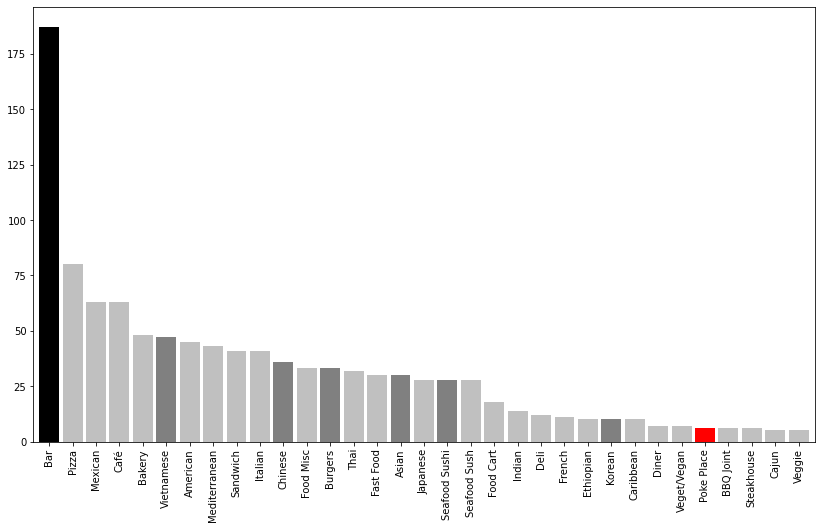

In [388]:
df_x = seattle_venues.drop(seattle_venues[seattle_venues["Venue Category"]=='Neighborhood'].index)

ax = df_x['Venue Category'].value_counts().plot(kind='bar', 
                                                   figsize=(14,8), 
                                                   width=.85,
                                                   color=['black','silver','silver','silver','silver','gray', 'silver','silver'
                                                          ,'silver','silver','gray','silver','gray','silver','silver','gray'
                                                          ,'silver','gray','silver','silver','silver','silver','silver','silver'
                                                          ,'gray','silver', 'silver','silver'
                                                          ,'red'
                                                          ,'silver','silver','silver','silver','silver','silver','silver', 'silver'
                                                          ,'silver','silver','silver','silver'
                                                         ])  

## 3.3 Examine the Clusters
#### 3.3.1 Cluster 1: (12) Zipcodes with No Poke Restaurants, Heavy Bar Presence, Median Age = 35-45

In [403]:
df_clus_1 = seattle_final.loc[seattle_final['Cluster Label'] == 0, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 1 for Patterns
print(df_clus_1.shape)
df_clus_1

(12, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue,11th Venue,12th Venue,13th Venue,14th Venue,15th Venue,16th Venue,17th Venue,18th Venue,19th Venue,20th Venue
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98102,Lake Union,Eastlake,Residential Urban Village,200.2,5084,37.000000,25.394605,0.281591,0.718409,47.632870,-122.32253,False,0,Bar,Italian,Bakery,Mexican,American,Burgers,Café,Indian,Sandwich,Food Cart,Thai,Seafood Sush,Pizza,Veget/Vegan,Mediterranean,Japanese,Steakhouse,Vietnamese,Food Misc,Ethiopian
98107,Ballard,"Ballard, Ballard-Interbay-Northend","Hub Urban Village, Manufacturing Industrial",1359.8,11736,36.716070,8.630681,0.289776,0.710224,47.667470,-122.37468,False,0,Bar,Mexican,Seafood Sushi,Sandwich,Pizza,American,Food Cart,Thai,Seafood Sush,Italian,Asian,Vietnamese,Café,French,Veget/Vegan,BBQ Joint,Bakery,Japanese,Burgers,Mediterranean
98108,Greater Duwamish,"South Park, Columbia City",Residential Urban Village,576.1,7385,35.906283,12.818955,0.389678,0.610322,47.546188,-122.31514,False,0,Bar,Café,Pizza,Japanese,Fast Food,Sandwich,Mexican,Mediterranean,Food Misc,French,Food Cart,Veggie,Seafood Sushi,Asian,Vietnamese,BBQ Joint,Chinese,Caribbean,Bakery,Diner
98109,Lake Union,South Lake Union,Urban Center,339.9,3774,39.100000,11.103266,0.124847,0.875153,47.630648,-122.34675,False,0,Bar,Mexican,Café,Food Misc,Veget/Vegan,Sandwich,Pizza,Italian,American,Steakhouse,Seafood Sush,Mediterranean,Korean,Japanese,Asian,Vietnamese,Food Cart,Cajun,Bakery,Veggie
98115,"Northeast, Northwest","Ravenna, Green Lake, Roosevelt","Urban Center Village, Residential Urban Village",389.2,8611,30.891139,22.124872,0.200225,0.799775,47.683820,-122.30122,False,0,Bar,Pizza,Mediterranean,Bakery,Café,American,Indian,Seafood Sushi,Sandwich,Japanese,Vietnamese,Chinese,Burgers,Mexican,Cajun,Veget/Vegan,Thai,Steakhouse,Caribbean,Veggie
98117,"Ballard, Northwest","Crown Hill, Greenwood-Phinney Ridge",Residential Urban Village,267.1,5386,37.997791,20.164732,0.447928,0.552072,47.685919,-122.37838,False,0,Bar,Pizza,Mexican,Café,Mediterranean,Food Misc,French,Food Cart,Thai,Bakery,Deli,Seafood Sushi,Sandwich,Italian,American,Vietnamese,Burgers,Caribbean,Cajun,Veggie
98119,Downtown,Uptown,Urban Center,333.1,7300,34.500000,21.915341,0.222092,0.777908,47.638770,-122.36694,False,0,Bar,Bakery,Café,Thai,Sandwich,Pizza,Mexican,Food Misc,American,Italian,Food Cart,Seafood Sushi,Japanese,Vietnamese,Burgers,Chinese,Fast Food,Poke Place,Veggie,Veget/Vegan
98125,"North, Northwest","Lake City, Northgate","Hub Urban Village, Urban Center",552.8,10268,35.922857,18.574530,0.174983,0.825017,47.716648,-122.30308,False,0,Bar,Mexican,Pizza,Mediterranean,Thai,Ethiopian,Sandwich,Vietnamese,Café,Seafood Sushi,Burgers,Bakery,Asian,Indian,Veget/Vegan,Steakhouse,Korean,Seafood Sush,Poke Place,Veggie
98126,Downtown,Morgan Junction,Residential Urban Village,113.7,2046,37.400000,17.994723,0.387842,0.612158,47.546870,-122.37480,False,0,Bar,Pizza,Fast Food,Chinese,Food Cart,American,Japanese,Mexican,Mediterranean,Food Misc,Vietnamese,Deli,Diner,BBQ Joint,Veggie,Veget/Vegan,Thai,Steakhouse,Seafood Sushi,Seafood Sush


#### 3.3.2 Cluster 2: (6) Zipcodes Already Have Poke Restaurant, Heavy Asian Restaurant Presence, Median Age 33-40

In [401]:
df_clus_2 = seattle_final.loc[seattle_final['Cluster Label'] == 1, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 2 for Patterns
print(df_clus_2.shape)
df_clus_2

(6, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue,11th Venue,12th Venue,13th Venue,14th Venue,15th Venue,16th Venue,17th Venue,18th Venue,19th Venue,20th Venue
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98101,"Downtown, East","Commercial Core, Pike/Pine, Denny Triangle",Urban Center Village,550.0,13578,39.133768,24.687273,0.217482,0.782518,47.610670,-122.33438,True,1,Bar,American,Italian,Bakery,Sandwich,Mediterranean,Café,Seafood Sush,Chinese,Food Misc,Veggie,Seafood Sushi,Poke Place,Pizza,Mexican,Japanese,French,Asian,Deli,Vietnamese
98103,"Lake Union, Northwest","Wallingford, Aurora-Licton Springs, Fremont","Residential Urban Village, Hub Urban Village",798.6,15489,33.413384,19.395192,0.335741,0.664259,47.671346,-122.34166,True,1,Bar,Burgers,Pizza,Café,Japanese,Bakery,Mexican,Caribbean,Thai,Seafood Sushi,Food Cart,American,Asian,Mediterranean,Seafood Sush,Indian,Poke Place,Food Misc,Fast Food,Diner
98104,"Downtown, East","Madison-Miller, First Hill, Pioneer Square","Residential Urban Village, Urban Center Village",515.8,14999,40.434656,29.079100,0.169605,0.830395,47.602520,-122.32855,True,1,Vietnamese,Bar,Chinese,Pizza,American,Japanese,Seafood Sushi,Bakery,Seafood Sush,Sandwich,Café,Italian,Thai,Poke Place,Mediterranean,Burgers,French,Food Misc,Deli,Diner
98118,"Southeast, Greater Duwamish","Othello, Columbia City",Residential Urban Village,687.6,11204,33.521823,16.294357,0.312762,0.687238,47.543348,-122.27496,True,1,Vietnamese,Bar,Mexican,Ethiopian,Bakery,Chinese,Food Misc,Pizza,Fast Food,Café,Cajun,Food Cart,Burgers,Seafood Sush,Italian,Poke Place,Mediterranean,Veget/Vegan,Thai,Veggie
98121,Downtown,Belltown,Urban Center Village,219.9,11961,39.800000,54.392906,0.235364,0.764636,47.614870,-122.34578,True,1,Bar,Bakery,Café,Seafood Sushi,Mediterranean,Italian,American,Food Misc,Seafood Sush,Pizza,Veggie,Thai,Poke Place,Japanese,French,Diner,Deli,Food Cart,Sandwich,BBQ Joint
98122,East,"Chinatown-International District, Capitol Hill",Urban Center Village,568.7,21745,36.664709,38.236328,0.171637,0.828363,47.611570,-122.30406,True,1,Bar,French,Mexican,Asian,Food Misc,Italian,Bakery,Café,Mediterranean,Fast Food,Burgers,Thai,Indian,Chinese,Seafood Sushi,Seafood Sush,Sandwich,Poke Place,Pizza,American


#### 3.3.3 Cluster 3: (2) Zipcodes with No Poke Restaurants, Zero Bar and Heavy Pizza Presence, Median Age 35

In [402]:
df_clus_3 = seattle_final.loc[seattle_final['Cluster Label'] == 2, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 3 for Patterns
print(df_clus_3.shape)
df_clus_3

(2, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue,11th Venue,12th Venue,13th Venue,14th Venue,15th Venue,16th Venue,17th Venue,18th Venue,19th Venue,20th Venue
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98168,Southeast,Rainier Beach,Residential Urban Village,267.5,3583,35.2,13.394393,0.25169,0.74831,47.491327,-122.30270,False,2,Vietnamese,Pizza,Mexican,Mediterranean,Indian,Veggie,Veget/Vegan,Thai,Steakhouse,Seafood Sushi,Seafood Sush,Sandwich,Poke Place,Korean,Japanese,Italian,American,Asian,Food Misc,Food Cart
98178,Southeast,Rainier Beach,Residential Urban Village,267.5,3583,35.2,13.394393,0.25169,0.74831,47.497971,-122.24664,False,2,Vietnamese,Pizza,Mexican,Mediterranean,Indian,Veggie,Veget/Vegan,Thai,Steakhouse,Seafood Sushi,Seafood Sush,Sandwich,Poke Place,Korean,Japanese,Italian,American,Asian,Food Misc,Food Cart


#### 3.3.4 Cluster 4: (8) Zipcodes with No Poke Restaurants, Wide Mix Restaurants and Bars, Median Age Spread 26-45

In [404]:
df_clus_4 = seattle_final.loc[seattle_final['Cluster Label'] == 3, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 4 for Patterns
print(df_clus_4.shape)
df_clus_4

(8, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue,11th Venue,12th Venue,13th Venue,14th Venue,15th Venue,16th Venue,17th Venue,18th Venue,19th Venue,20th Venue
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98105,Northeast,Admiral,Residential Urban Village,98.3,1528,42.300000,15.544252,0.269231,0.730769,47.663770,-122.301180,False,3,Bar,Asian,Burgers,Café,Pizza,American,Deli,Indian,Seafood Sushi,Chinese,Thai,Veget/Vegan,Italian,Korean,Steakhouse,Seafood Sush,Mexican,Mediterranean,Veggie,Vietnamese
98106,Delridge,Westwood-Highland Park,Residential Urban Village,275.5,4606,36.800000,16.718693,0.409465,0.590535,47.532820,-122.354430,False,3,Fast Food,Sandwich,Bakery,Bar,Burgers,Café,Mexican,Thai,Japanese,Pizza,American,Mediterranean,Poke Place,Steakhouse,Seafood Sush,Seafood Sushi,Veget/Vegan,Veggie,Korean,French
98116,Southwest,West Seattle Junction,Hub Urban Village,225.8,3788,42.900000,16.775908,0.323580,0.676420,47.574870,-122.393920,False,3,Pizza,Mexican,Bar,Fast Food,Food Misc,Italian,American,Vietnamese,Burgers,Asian,Food Cart,Mediterranean,Sandwich,Seafood Sush,Thai,Cajun,Café,Indian,Japanese,Steakhouse
98133,Northwest,Bitter Lake Village,Hub Urban Village,358.7,4273,37.900000,11.912462,0.224715,0.775285,47.733852,-122.344610,False,3,Asian,Vietnamese,Korean,Chinese,Thai,Sandwich,Mexican,American,Bakery,Burgers,Fast Food,Café,Seafood Sush,Bar,Veggie,Veget/Vegan,BBQ Joint,Steakhouse,Seafood Sushi,Poke Place
98144,"East, Greater Duwamish","Chinatown-International District, Columbia Cit...","Urban Center Village, Residential Urban Village",614.6,10303,42.567184,16.763749,0.190322,0.809678,47.585770,-122.300810,False,3,Vietnamese,Pizza,Bar,Fast Food,Mexican,Asian,Bakery,Café,Sandwich,Ethiopian,Thai,Japanese,Food Misc,Caribbean,Italian,Seafood Sush,Mediterranean,American,Chinese,BBQ Joint
98146,Southwest,West Seattle Junction,Hub Urban Village,225.8,3788,42.900000,16.775908,0.323580,0.676420,47.501753,-122.356880,False,3,Pizza,Mexican,Bar,Fast Food,Food Misc,Italian,American,Vietnamese,Burgers,Asian,Food Cart,Mediterranean,Sandwich,Seafood Sush,Thai,Cajun,Café,Indian,Japanese,Steakhouse
98188,Greater Duwamish,Greater Duwamish,Manufacturing Industrial,4961.2,1064,44.500000,0.214464,0.180473,0.819527,47.450321,-122.274720,False,3,American,Thai,Burgers,Chinese,Mexican,Asian,Sandwich,Italian,Fast Food,Indian,Steakhouse,Seafood Sushi,Seafood Sush,Pizza,Japanese,Vietnamese,Café,Diner,BBQ Joint,Bakery
98195,Northeast,"University District Northwest, University Campus",Urban Center Village,635.0,19381,26.561622,30.521260,0.060910,0.939090,47.651111,-122.311111,False,3,Café,Mediterranean,Bar,American,Asian,Seafood Sush,Burgers,Sandwich,Mexican,Korean,Italian,Vietnamese,Deli,Chinese,Veggie,Diner,Indian,Thai,Caribbean,Fast Food


#### 3.3.5 Cluster 5: (1) Zipcodes with No Poke Restaurants, Heavy Asian Restaurants Presence, Median Age Spread 39

In [405]:
df_clus_5 = seattle_final.loc[seattle_final['Cluster Label'] == 4, seattle_final.columns[[0] + list(range(1, seattle_final.shape[1]))                                                                          ]]

# Analyze Cluster 5 for Patterns
print(df_clus_5.shape)
df_clus_5

(1, 33)


,Boroughs,Neighborhoods,Types,Acres,Total_Pop,Median_Age,Pop_Dens,Prc_Own,Prc_Rent,Latitude,Longitude,HasPoke,Cluster Label,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue,11th Venue,12th Venue,13th Venue,14th Venue,15th Venue,16th Venue,17th Venue,18th Venue,19th Venue,20th Venue
Zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98177,Southeast,North Rainier,Hub Urban Village,455.0,4908,39.7,10.786813,0.349586,0.650414,47.740886,-122.36978,False,4,Chinese,American,Seafood Sushi,Asian,Vietnamese,Burgers,Café,Veggie,Veget/Vegan,Thai,Steakhouse,BBQ Joint,Seafood Sush,Sandwich,Poke Place,Pizza,Mexican,Mediterranean,Korean,Japanese


## 4. Footnotes <a name="footnotes"></a>

In [ ]:
[1] https://hospitalityinsights.ehl.edu/poke-bowl-trend   
[2] https://www.mamamia.com.au/are-poke-bowls-healthy 
[3] https://parade.com/925822/marysauer/are-poke-bowls-healthy 
[4] https://www.theifod.com/why-do-competitors-often-put-their-stores-next-to-each-other 
[5] https://web.stanford.edu/class/cs345a/slides/12-clustering.pdf 
[6] https://www.eater.com/2018/11/6/18057316/poke-bowl-trend-fast-casual-restaurant-closures 
[7] https://www.google.com/maps/search/poke+restaurants+seattle/@47.6710717,-122.3602199,11z/data=!3m1!4b1!4m2!2m1!6e5 
[8] https://opendata.arcgis.com/datasets/5319b05188d744319e01b4ce4be6b853_0.csv
[9] https://developer.foursquare.com/docs/places-api/endpoints/
[10] https://foursquare.com/about/ 
[11] https://developer.foursquare.com/developer/ 
[12] http://www.agingkingcounty.org/wp-content/uploads/sites/185/2016/09/SubRegZipCityNeighborhood.pdf 
[13] https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=WA&q=Seattle